<a href="https://colab.research.google.com/github/mvenouziou/Project_Style_Transfer/blob/master/Audio_Visual_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio + Image Style Transfer Model

This app takes a 'content' (image / audio) and adapts it with texture elements from a second source (image / audio). 

- Audio style transfer is implemented in EXPERIMENTAL stage. (It is fully functional in generating a new audio. However, it is hard to understand what 'style' elements are being transferred. I'm searching for approprate paramaters / audio filters / models to generate more interpretable results.)

- To test out the audio style transfer using Google Colab: upload your audio files to '/content/' directory and update filenames in 'AUDIO_OPTIONS' global paramaters, then run all cells. Audio style is on the last cell.)

- Try my web app implementation for image style transfer at www.communicatemission.com/ml-projects#style_transfer.

---
### Traditional Implementation (Images):

The Neural Style Transfer method is used to alter a base image ("content image") with stylistic elements from a second image ("style image"). The generated image is obtained by imposing two costs - the "distance" between generated image and features extracted from the style and content images - in order to train a model.

There are two main challenges in this approach: how to extract useful features and how to measure distance. 

Feature extraction is accomplished by running images through a pre-trained CNN (such as the VGG19 image classification model) and selecting a weighted combination of layout outputs. 

Style cost measures the difference in gradients between style and generated image outputs from lower-level layers, as measured by a Gram matrix. Content cost is measured using the values (not gradients) of higher level layer outputs and/or the raw images.  

---
### New Implementation (Audio):

Adapting this procedure to audio introduces two additional challenges: converting the audio into a 2D image (for use in the pretrained CNN) and then producing audio as an output.

My initial strategy was to convert the audio into a spectral image using a discrete Fourier Transform (SFTF) and various audio filters, followed directly by the pretrained VGG net. Since this is not an invertible process (for transforming the resulting image back into audio), only the style costs are measured using the network. Content costs instead rely exclusively on invertible transformations, such as SFTF.

Even though this audio generation model technically works, it isn't obvious what exactly the relationship between the audio 'style' and generated music style is. This might be an issue of choosing better paramaters. 

I'm currently:
- Searching for more optimal paramaters
- Considering alternate pretrained models for transfer learning. YAMNet audio classification model available on Tensorflow HUB apears promising. It is philisophically similar to the above approach (convert audio to image with a spectrogram and then use an image CNN architecture), but was specifically developed and trained for audio classification.  Unfortunately Tensorflow HUB's version doesn't appear to give direct access to the model's individual layers, so it will take some extra time to implement it in my model.


---
### Credits / Attributions:

Audio Style Transfer:

- This is an original creation, by which I mean that I created it without having seen this done elsewhere. Perhaps I will find it elswhere upon conducting a literature review. 

- I learned the basic concept of representing audio as an image in order to apply pretrained CNN models from *Deep Learning for Coders with fastai & Pytorch* by Howard and Gugger (2020). It also appears in Tensorflow documentation *www.tensorflow.org/tutorials/audio/simple_audio* for classification tasks.

- (To be implemented) The pretrained YAMNet model is available on Tensorflow HUB *https://tfhub.dev/google/yamnet/1*. It transforms audio into 2D spectral representations, followed by a CNN based on Mobilenet_v1 depthwise-separable convolution architecture. Details are on their GitHub page *https://github.com/tensorflow/models/tree/master/research/audioset/yamnet*.

Image Content & Style Models:

- This has been been coded heavily relying on techniques from DeepLearning.ai specialization on Coursera *(www.coursera.org/learn/convolutional-neural-networks)* and the Tensorflow style transfer documentation (www.tensorflow.org/tutorials/generative/style_transfer), which are in turn based on a paper by Gatys, Ecker and Bethge (*https://arxiv.org/abs/1508.06576*)

- The web app is built on the Anvil platform.

- Pretrained image models used are loaded from the tf.keras.applications model. This model currently usilizes VGG19 (*Very Deep Convolutional Networks for Large-Scale Image Recognition (ICLR 2015))*

Images from photographers posted on Unsplash.com :

- <a href="https://unsplash.com/@abm25?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Aida Batres*</a>
- <a href="https://unsplash.com/@bmowinkel?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Brandon Mowinkel*</a>
- <a href="https://unsplash.com/@autumnstudio?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Autumn Studio*</a>
- <a href="https://unsplash.com/@joshhild?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Josh Hild*</a>
- <a href="https://unsplash.com/@pawel_czerwinski?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Paweł Czerwiński*</a>
- <a href="https://unsplash.com/@lucassankey?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Lucas Sankey*</a>
- <a href="https://unsplash.com/@ivanana?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Ivana La*</a>
- <a href="https://unsplash.com/@charlesdeluvio?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Charles Deluvio*</a>
- <a href="https://unsplash.com/@sharonp?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">*Sharon Pittaway*</a>

In [ ]:
#### REQUIRED IMPORTS ####

# ML design
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model, Sequential
import tensorflow_probability as tfp

# data handling
import numpy as np
from PIL import Image
!pip install librosa -q  # audio processing
import librosa

# computations
from scipy.special import expit, logit
from scipy.signal.windows import hann
from scipy import signal

# visualization
import matplotlib.pyplot as plt 
%matplotlib inline
import IPython.display as display

# audio
from IPython.display import Audio

# file management
import pickle

##### GLOBAL VARIABLES
File directories and hyperparameters

In [ ]:
# GLOBAL VARIABLES - Parameters
PIXELS = 224
SIZE = (PIXELS, PIXELS)
CONTENT_WEIGHT = 10.
STYLE_WEIGHT = 1.

In [ ]:
# GLOBAL VARIABLES - File Structure

# 3rd Party Integrations (enabled / disabled)
USE_ANVIL = False
USE_GOOGLE_DRIVE = False

# File Directory Structure
# images datasets (Github)
IMAGES_DIR = \
    'https://raw.githubusercontent.com/mvenouziou/Style_Transfer/master/'

AUDIO_DIR = '/content/'

# saved models (Google Drive)
GDRIVE_DIR = '/content/gdrive/'
FILEPATH = GDRIVE_DIR + 'MyDrive/Colab_Notebooks/models/style_transfer/'
CHECKPOINT_DIR = FILEPATH + 'checkpoints/'
CACHE_DIR = FILEPATH + 'cache/'
GENERATED_IMAGES_DIR = FILEPATH + 'generated_images/'

# mount google drive:
if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount(GDRIVE_DIR)

# connect to Anvil web app server
if USE_ANVIL:
    # Anvil Web App server
    !pip install anvil-uplink
    import anvil.server
    anvil.server.connect("VCUVGCO27TQO6VER2T6YMM4K-FXYOFTHT5SD2KYNR")
    import anvil.media

In [ ]:
# GLOBAL VARIABLES - Images

# available images (free license images sourced from unsplash.com)
IMAGE_OPTIONS = \
    {'dog':'ivana-la-Dhlwt-VOmeM-unsplash.jpg',
     'dog2':'charles-deluvio-Mv9hjnEUHR4-unsplash.jpg',
     'protest': 'josh-hild-RD0BXCGemEY-unsplash.jpg',
     'statue_of_liberty': 'brandon-mowinkel-UGi_Ng56FRI-unsplash.jpg',
     'two_color_straight': 'autumn-studio-PaM7SD5wM6g-unsplash.jpg',
     'flowers': 'aida-batres-_QxzSVWesm0-unsplash.jpg',
     'flowers2': 'sharon-pittaway-iMdsjoiftZo-unsplash.jpg',
     'colors_wild': 'pawel-czerwinski-g2Zf3hJyYAc-unsplash.jpg',
     'flag': 'lucas-sankey-gdQ_az6CSPo-unsplash.jpg',
     }

AUDIO_OPTIONS = {#'song1': 'song1.wav',
                 'song1': "01 - Beck - Devil's Haircut.m4a",
                 'song2': "05 - Beck - Derelict.m4a",
                 'song3': '06 Persuasion.mp3',
                 'song4': '04 - Charlie Parker - Bloomdido.mp3'}

# audio transforms
""" # not yet to be implemented
# ## Fourier transfrom with YASNet paramaters as described in
# github.com/tensorflow/models/tree/master/research/audioset/yamnet#input-audio-features
yamnet_preproc = {'trans_func': librosa.stft,  # Short-time Fourier Transform (STFT)
                 'inv_trans_func': librosa.istft,  # Short-time Fourier Transform (STFT)
                 'n_fft': 2 ** 9,  # 2** int(np.ceil(np.log(16000 * .025))/np.log(2.0)),
                 'hop_length': 10,
                 'win_length':hann(M=25, sym=False),
                 }
"""

# ## Fourier (Librosa)
fourier = {'trans_func': librosa.stft,  # Short-time Fourier Transform (STFT)
           'inv_trans_func': librosa.istft,  # Short-time Fourier Transform (STFT)
           'n_fft': 2048,
           'hop_length': 2048//4,
           }

# constant-Q
constant_Q = {'trans_func': librosa.cqt,
              'inv_trans_func': librosa.icqt,
              'hop_length': 1 * (2**6),
              }
tempogram = {'trans_func': librosa.feature.tempogram,
              'inv_trans_func': None,
              'hop_length': 512,
              }
AUDIO_TRANSFORM_PARAMS = {'Fourier': fourier,
                          'constant_Q': constant_Q,
                          'tempgram': tempogram}

# available transfer learning base models
TRANSFER_MODEL_OPTIONS = \
    {'vgg_for_image': tf.keras.applications.VGG19, # ImageNet VGG Very Deep 19
     'vgg_for_audio': tf.keras.applications.VGG19,  # selects different layers
   #  'yamnet': 'https://tfhub.dev/google/yamnet/1',  # to be implemented
     }

#### Load pretrained VGG net as base model for transfer learning

In [ ]:
# load pre-trained model for extracting style layers
def load_base_model(transfer_model_name, 
                    transfer_model_options=TRANSFER_MODEL_OPTIONS):
    
    """
    ##### parameters set for using VGG
    To do: add more model options
    """
    # select model
    # ## VGG19 params for image style transfer
    if transfer_model_name == 'vgg_for_image':
        model = transfer_model_options[transfer_model_name]

        # load model
        source_model = model(include_top=False, 
                            weights='imagenet', 
                            input_tensor=None, 
                            input_shape=None, 
                            pooling=None, 
                            classifier_activation='softmax')
        
        # select layers for feature extraction
        layer_weights = {#2: 0.2,  # Conv2D layer weightings
                          #5: 0.2,
                          #10: 0.2,
                          12: 0.2,
                          #15: 0.2,
                          #20: 0.2,
                          #21: .01,  # final layer (MaxPooling2D)
                          }

    # ## VGG19 params for audio style transfer
    elif transfer_model_name == 'vgg_for_audio':
        model = transfer_model_options[transfer_model_name]

        # load model
        source_model = model(include_top=False, 
                            weights='imagenet', 
                            input_tensor=None, 
                            input_shape=None, 
                            pooling=None, 
                            classifier_activation='softmax')
        
        # select layers for feature extraction
        layer_weights = {#2: 0.2,  # Conv2D layer weightings
                          #5: 0.2,
                          #10: 0.2,
                          #12: 0.2,
                          15: 0.2,
                          20: 0.2,
                          #21: .01,  # final layer (MaxPooling2D)
                          }
    
    """
    # ## YAMNet 
    elif transfer_model_name == 'yamnet':
        tf_hub_url = transfer_model_options[transfer_model_name]

        # load model
        source_model = hub.load(tf_hub_url)

        # select layers for feature extraction
        layer_weights = {#2: 0.2,  # Conv2D layer weightings
                          #5: 0.2,
                          #10: 0.2,
                          12: 0.2,
                          #15: 0.2,
                          #20: 0.2,
                          #21: .01,  # final layer (MaxPooling2D)
                          }
    """

    # lock models for transfer learning
    source_model.trainable = False  

    return source_model, layer_weights

Get source contant / style files

In [ ]:
def load_image_from_URL(image_name, 
                        images_directory=IMAGES_DIR,
                        image_options=IMAGE_OPTIONS,
                        cache_dir=CACHE_DIR):
    
    # choose from saved options
    filename = image_options[image_name]
    image_path = tf.keras.utils.get_file(filename, 
                                    origin=images_directory + filename,
                                    cache_subdir=cache_dir)

    return image_path


def load_audio_from_URL(audio_name, 
                       audio_directory=AUDIO_DIR,
                       audio_options=AUDIO_OPTIONS):
    
    # choose from saved options
    filename = audio_options[audio_name]
    audio_clip = librosa.load(path = audio_directory + filename, 
                              sr=22050,
                              mono=True, offset=0.0, 
                              duration=20, #
                              res_type='kaiser_best')
    audio_clip = audio_clip[0]
    print('audio_clip:', audio_clip.shape)


    return audio_clip

#### Image Preprocessing

In [ ]:
# load and prepare images for model
def prepare_images(image_path, size):
    """ converts images to tensors and standardizes for model """

    # load images as PIL and resize
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=size)

    # convert to array and standardize
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.

    # add batch dimension and convert to tensor: (1, height, width, channels)
    image = tf.expand_dims(image, axis=0)

    # record original image (relative) dimensions 
    # (to produce undistorted final image)
    orig_image = tf.keras.preprocessing.image.load_img(image_path, target_size=None)
    orig_image = tf.keras.preprocessing.image.img_to_array(orig_image)
    orig_shape = orig_image.shape[:2]

    return image, orig_shape


def initialize_generated_image(input_image, noise_rate):
    """ creates noisy version of content image """

    # define random noise
    noise = tf.random.uniform(shape=input_image.shape, minval=-1, maxval=1)
    
    # update image
    image = noise * noise_rate + input_image * (1 - noise_rate)

    # convert to tensor
    image_tensor = tf.convert_to_tensor(image)
    
    return image_tensor

Audio Preprocessing

In [ ]:
def audio_transformed(audio_clip, transform='Fourier', 
                   transform_params=AUDIO_TRANSFORM_PARAMS):
    """ (Near lossless /invertible) operations 
    to represent audio signal as array"""
    
    # get transform paramaters
    params = transform_params[transform]
    trans_func = params['trans_func']
    n_fft = params['n_fft']
    hop_length = params['hop_length']
    
    # apply transform to audio clip
    transformed = trans_func(audio_clip, n_fft, hop_length )  

    # resampling for matching YAMNet
    # apply transform to audio clip
    audio_clip_resamples = librosa.resample(audio_clip, orig_sr=16000, target_sr=22050, 
                        res_type='kaiser_best', fix=True, scale=False)
    transformed_resample = trans_func(audio_clip, n_fft, hop_length ) 

    

    return transformed, transformed_resample


def complex_transform_to_image(transformed, transform='Fourier', 
                               transform_params=AUDIO_TRANSFORM_PARAMS, 
                               raw_audio=None):
    """ convert complex valued matrix (array) into an RGB representation.
    Can apply audio filters to extract audio style elements.

    Not required to be invertible operations """
    
    
    # apply filters / extract features
    if raw_audio is not None:  # alternate transform
        transformed = librosa.feature.fourier_tempogram(y=raw_audio)

    else:
        # follow YAMNet's paramaters to create Mel-bank spectrogram
        
        # note: to create log Mel-bank magnitude spectrogram use
        # transformed = np.abs(transformed)  

        n_fft = transform_params[transform]['n_fft']
        filter = librosa.filters.mel(sr=16000, 
                                     n_fft=n_fft,
                                     n_mels=25,
                                     fmin=125,
                                     fmax=7500)
        transformed = np.dot(filter, transformed)

        transformed = np.log(transformed + .001)

    # convert to RGB
    rgb = np.dstack((transformed.real, transformed.imag, 
                     np.abs(transformed)))

    # map values into interval [0, 1]
    # using scipy.special.expit (sigmoid function)
    #rgb = expit(rgb)
    rgb = (rgb + np.min(rgb)) / np.max(rgb + np.min(rgb))
    
    # add batch dimension: (1, r, g, b)
    image_tensor = tf.expand_dims(rgb, axis=0)

    return image_tensor


def audio_to_image(audio_clip, size=SIZE, show_image=True, transform='Fourier', 
                   transform_params=AUDIO_TRANSFORM_PARAMS):
    """ converts an audio clip to a spectrogram-type image (tensor)."""

    
    # apply lossless audio to array transformation
    transformed, transformed_resample = \
                audio_transformed(audio_clip, transform='Fourier', 
                                  transform_params=AUDIO_TRANSFORM_PARAMS)
    
    # convert into an RGB representation
    image_tensor = complex_transform_to_image(transformed_resample)

    # note: resizing for pre-trained model input will occur in loss function
    # so full res audio can be used for content cost

    return image_tensor[0], transformed


def audio_player(audio_clip, smoothing=0):
    # get audio player using IPython.display.Audio
    
    if smoothing != 0:  # scipy.signal.windows.hann
        window = hann(smoothing)
        audio_clip = signal.convolve(audio_clip, window, 
                                     mode='same')
    file_player = Audio(np.sin(audio_clip), 
                        rate=22050, 
                        autoplay=True)
    return file_player


def tensor_to_audio(tensor, transform='Fourier', 
                    transform_params=AUDIO_TRANSFORM_PARAMS):
    """ applied inverse transform on tensor
     Returns: audio (as numpy array), audio file player """

    # drop batch dim and convert to numpy
    transformed_array = tf.squeeze(tensor).numpy()

    # reverse STFT representation
    # ## get paramaters
    params = transform_params[transform]
    trans_func = params['inv_trans_func']
    hop_length = params['hop_length']
    
    # ## apply transformation
    audio_clip = trans_func(transformed_array, hop_length=hop_length)

    # get audio player using IPython.display.Audio
    file_player = audio_player(audio_clip)
    
    return audio_clip, file_player

Image viewer

In [ ]:
def view_tensor_as_image(tensor, output_shape, show=True, already_numpy=False): 
    
    if already_numpy:  # convert numpy arrays to tensor
        tensor = tf.constant(tensor)
    
    # rescale [0, 1] RGB values to [0, 255]
    tensor_image = tensor * 255
    
    # remove dummy dimension (representing batch_size component)
    tensor_image = tf.squeeze(tensor_image)

    # rescale dimensions
    output_shape = list(output_shape)
    tensor_image = tf.image.resize(images=tensor_image, 
                                   size=output_shape)
    
    # convert image
    image_array = tensor_image.numpy()
    image_array = np.squeeze(image_array)
    image = tf.keras.preprocessing.image.array_to_img(
                    image_array, data_format=None, scale=True, dtype=None)

    # show image
    if show:
        display.clear_output(wait=True)
        display.display(image)
    return image, tensor_image, image_array

#### Custom Cost Functions
Measures the differences between generated image and 1) content image and 2) style layers from style image.

In [ ]:
### Cost Functions - Image Content
# this cost component helps generated image resemble the content image
def content_cost(learned_tensor, orig_tensor):

    # scale factor to make invariant to input dimensions
    # value similar to that recommended in DeepLearning.AI course
    scale_factor = 1 / (tf.math.reduce_prod(tf.shape(orig_tensor)))
    scale_factor = tf.cast(scale_factor, dtype=tf.float32)

    # compute cost as distance between source image and generated image
    distance = tf.cast(learned_tensor - orig_tensor, dtype=tf.float32)
    cost = scale_factor * tf.norm(tensor=distance, ord=2)#'euclidean')

    return cost

In [ ]:
### Cost Functions - Gradient Content (represents image style)
# this cost component helps generated image resemble the style image's texture
# it is applied to interior image layer activation(s)

# measures the difference in gradients between image and generated images
def gram_matrix(image):
    """
    Computes Gram Matrix
    Parameter: tensors of shape (px_width, px_height, channels)
    """

    num_channels = image.shape[-1]
    image = tf.reshape(image, [-1, num_channels])
    gram = tf.linalg.matmul(image, image, transpose_a=True, transpose_b=False)

    return gram


# adds up gram_matrix across chosen layers
def style_cost(style_activations, generated_activations, weights):

    # initialize cost
    cost = 0

    for layer in weights.keys():

        # get content data
        style_activ = style_activations[layer]
        generated_activ = generated_activations[layer]
        weight = weights[layer]

        # scale factor to make invariant to input dimensions
        # (uses squared terms to balance out Gram matrix, which is essentially square term)
        # value asimilar to that recommended in DeepLearning.AI course
        scale_factor = 1 / (tf.math.reduce_prod(tf.shape(style_activ))**2)
        scale_factor = tf.cast(scale_factor, dtype=tf.float32)

       # compute distance between style and generated gradients
        gram_style = gram_matrix(style_activ)
        gram_generated = gram_matrix(generated_activ)
        distance = gram_style - gram_generated

       # compute cost
        cost += weight * scale_factor * tf.norm(distance, ord=2)**2

    return cost

#### Forward Pass Definition

Style Activations

In [ ]:
def learn_activations(input_tensor, orig_model, layer_nums):
    """
    Conducts forward pass of given model and stores activations
    indicated by layers list.
    """

    # initialize activations container
    activations_computed = dict()

    # forward passes through selected layers
    x = input_tensor

    for k in range(len(layer_nums)):
        if k==0:
            start_layer = 0
        else:
            start_layer = layer_nums[k-1] + 1
            
        end_layer = layer_nums[k]
        
        # travel through model to next desired activation layer
        for layer_number in range(start_layer, end_layer+1):
            x = orig_model.layers[layer_number](x)
        
        # record activation
        activations_computed[end_layer] = x

    return activations_computed

Loss Function

In [ ]:
def loss_function(learned_tensor, orig_content_tensor, 
                  cnn_model, style_activations, layers_dict,
                  content_weight, style_weight):

    # prepare tensor's image representation
    if len(learned_tensor.shape) == 4:  # true for images
        learned_image = learned_tensor

        # clip image values to stay in [0,1] 
        learned_image = tf.clip_by_value(
                            learned_image, 
                            clip_value_min=0.0, 
                            clip_value_max=1.0
                            )
    
    else:  # for audio
        # convert to image representation
        learned_image = complex_transform_to_image(learned_tensor.numpy())
        
        # reduce image to size required by pretrained image network
        learned_image = tf.image.resize(learned_image, size=(224, 224),
                                method='bilinear')
    
    # get parameters
    layers = list(layers_dict.keys())
    
    # get activations
    generated_activations = \
        learn_activations(learned_image, cnn_model, layers)
        
    # compute loss
    loss = content_weight * content_cost(learned_tensor, 
                                         orig_content_tensor) + \
            style_weight * style_cost(style_activations, 
                                        generated_activations, 
                                        layers_dict)        

    return loss, learned_image

Training Step

In [ ]:
def training_step(learned_tensor, orig_content_tensor, 
                  cnn_model, optimizer, 
                  style_activations, layers_dict,
                  content_weight, style_weight):
    
    with tf.GradientTape() as tape:
        tape.watch(learned_tensor)

        # get loss
        loss, learned_image = \
                loss_function(learned_tensor=learned_tensor,
                              orig_content_tensor=orig_content_tensor, 
                              cnn_model=cnn_model,
                              style_activations=style_activations, 
                              layers_dict=layers_dict,
                              content_weight=content_weight, 
                              style_weight=style_weight)

        # get gradients
        grads = tape.gradient(loss, learned_tensor)

        # backward pass
        optimizer.apply_gradients([(grads, learned_tensor)])

    return loss, grads, learned_tensor, learned_image


In [ ]:
def train_generated_image(init_generated_tensor, image_activations, 
                          style_activations, cnn_model, 
                          content_weight, style_weight, 
                          num_iterations, learning_rate, 
                          orig_content_tensor,
                          layers_dict,
                          audio_style_mode=False,
                          output_shape=(224, 224),
                          checkpoint_dir=CHECKPOINT_DIR,
                          generated_images_dir=GENERATED_IMAGES_DIR):

    # initialize containers
    computed_images_dict = dict()

    # initialize trainable variables 
    learned_tensor = tf.Variable(init_generated_tensor)
    
    # init generated image
    if len(tf.shape(learned_tensor)) == 4:
        learned_image = learned_tensor
    else:
        learned_image = complex_transform_to_image(learned_tensor.numpy())

    # set optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                                         epsilon=1e-1, amsgrad=True,)
    
    # (note: custom loss function is defined within training loop)

    # show initial generated image
    print('Original image:\n')
    view_tensor_as_image(learned_image, output_shape, show=True)

    # training loop
    for iteration in range(num_iterations):
        
        # enforce image as trainable variable
        # (may convert to 'eager tensor' during computations and cause error)
        learned_tensor = tf.Variable(learned_tensor)
        
        # take one training step
        loss, grads, learned_tensor, learned_image = \
                training_step(learned_tensor=learned_tensor, 
                            orig_content_tensor=orig_content_tensor, 
                            optimizer=optimizer,
                            cnn_model=cnn_model,
                            style_activations=style_activations, 
                            layers_dict=layers_dict,
                            content_weight=content_weight,
                            style_weight=style_weight)

        # save progress and give status updates
        # report results / save checkpoints
        if iteration % 20 == 0:
            
            # report status
            print("iteration:", iteration)
            print("loss:", loss.numpy())

            # show generated image
            view_tensor_as_image(learned_image, output_shape, show=True)

            # save generated image in checkpoint            
            if USE_GOOGLE_DRIVE:
                
                save_filename = checkpoint_dir + 'learned_im_tensor_' + \
                                '_iter_' + str(iteration) + '.pickle'

                with open(save_filename, 'wb') as handle:
                    pickle.dump(image, handle, 
                                protocol=pickle.HIGHEST_PROTOCOL)
    
    # training ends                
    # show results
    print("Final loss:", loss.numpy())

    # convert back to viewable image (tensor)
    final_image, tensor_image, image_array = \
        view_tensor_as_image(learned_image, output_shape, show=True)

    # save result
    if USE_GOOGLE_DRIVE:
        save_filename = generated_images_dir + 'learned_im.jpg'
        tf.keras.preprocessing.image.save_img(save_filename, 
                                              learned_image)

    return final_image, learned_tensor, image_array


In [ ]:
def style_transfer(saved_variables, content_name, style_name, 
                   transfer_model_name, learning_rate,num_iterations,
                   checkpoint_dir=CHECKPOINT_DIR, content_weight=CONTENT_WEIGHT,
                   style_weight=STYLE_WEIGHT):

    print('Note: Generated image may take time to converge)\n' +
       'Use of GPU or low number of iterations highly recommended')

    """
    note: 
        saved_variables[transfer_model_name] = \
                    {'transfer_model': model,
                    'activations': activations_dict,
                    'layers_dict': layers_dict,
                    'init_generated_tensor': init_generated_tensor_dict,
                    'source_tensors': source_tensors_dict,
                    'output_shape': output_shapes_dict,
                    }
    """

    # select model paramaters dictionary
    model_variables = saved_variables[transfer_model_name]

    # get transfer base model
    transfer_model = model_variables['transfer_model']
    
    # get prepared images
    content_tensor = model_variables['source_tensors'][content_name]
    style_tensor = model_variables['source_tensors'][style_name]
    init_generated_tensor = \
        model_variables['init_generated_tensor'][content_name]

    output_shape = model_variables['output_shape'][content_name]
    
    # get CNN layer numbers for transfer
    layers_dict = model_variables['layers_dict']

    # get activations based on pretrained transfer model
    # (these are held constant throughout training loop)
    image_activations = model_variables['activations'][content_name]
    style_activations = model_variables['activations'][style_name]

    # generate new image / train model
    learned_image = \
        train_generated_image(init_generated_tensor=init_generated_tensor, 
                              image_activations=image_activations, 
                              style_activations=style_activations, 
                              cnn_model=transfer_model, 
                              layers_dict=layers_dict, 
                              content_weight=content_weight, 
                              style_weight=style_weight, 
                              num_iterations=num_iterations,
                              learning_rate=learning_rate,
                              orig_content_tensor=content_tensor,
                              output_shape=output_shape,
                              checkpoint_dir=checkpoint_dir
                              )

    return learned_image

Preload prepared image / models



In [ ]:
# Preload prepared image / models

def preload_variables(transfer_model_options=TRANSFER_MODEL_OPTIONS,
                      image_options=IMAGE_OPTIONS,
                      audio_options=AUDIO_OPTIONS,
                      noise_rate=.1,
                      size=SIZE):

    # initialize containers
    transfer_models_dict = {}

    # prepare transfer model
    for model_name in transfer_model_options:

        # initialize containers
        source_tensors_dict = {}
        init_generated_tensor_dict = {}
        activations_dict = {}
        output_shapes_dict = {}

        # get model and chosen layer params
        model, layers_dict \
            = load_base_model(model_name, transfer_model_options)

        # get layer numbers for activation computations
        layers = list(layers_dict.keys())  

        # process each image
        for name in {**image_options , **audio_options}:  # merged dicts

            # load images
            if name in image_options:
                print(f'loading image: {name}')

                # load and preprocess as tensor
                image_path = load_image_from_URL(name)
                source_tensor, output_shape = prepare_images(image_path=image_path, 
                                                            size=size)
                
                # initialize corresponding generated image
                init_generated_tensor = \
                    initialize_generated_image(source_tensor, noise_rate=noise_rate)

                # record shape (scaled down)
                max_dim = max(output_shape)
                scaled_output_shape = (max(size) * output_shape[0]//max_dim, 
                                        max(size) * output_shape[1]//max_dim)
                output_shapes_dict[name] = scaled_output_shape

                # compute activations
                activations = learn_activations(source_tensor, model, layers)

            # load audio
            if name in audio_options:
                print(f'loading audio: {name}')

                # load and preprocess as tensor
                audio_clip = load_audio_from_URL(name)
                rgb_conversion, source_tensor = \
                    audio_to_image(audio_clip, show_image=False)

                rgb_conversion = tf.expand_dims(rgb_conversion, axis=0)

                # initialize corresponding generated image=           
                init_generated_tensor = \
                    initialize_generated_image(source_tensor, noise_rate=0.01)
            
                # record shape (not scaled to minimize distortion)
                output_shapes_dict[name] = (output_shape[0], output_shape[1])

                # compute activations (using audio's image representation)
                activations = learn_activations(rgb_conversion, model, layers)
            
            # save in dict
            source_tensors_dict[name] = source_tensor
            init_generated_tensor_dict[name] = init_generated_tensor
            activations_dict[name] = activations

        # organize outputs
        transfer_models_dict[model_name] = \
            {'transfer_model': model,
            'activations': activations_dict,
            'layers_dict': layers_dict,
            'init_generated_tensor': init_generated_tensor_dict,
            'source_tensors': source_tensors_dict,
            'output_shape': output_shapes_dict,
            }

    return transfer_models_dict

Pre-load Images, Model and Activations

In [ ]:
SAVED_VARIABLES_DICT = preload_variables(
                            transfer_model_options=TRANSFER_MODEL_OPTIONS,
                            image_options=IMAGE_OPTIONS,
                            audio_options=AUDIO_OPTIONS,
                            noise_rate=.1,
                            size=SIZE)

loading image: dog
loading image: dog2
loading image: protest
loading image: statue_of_liberty
loading image: two_color_straight
loading image: flowers
loading image: flowers2
loading image: colors_wild
loading image: flag
loading audio: song1


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


audio_clip: (441000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


loading audio: song2
audio_clip: (441000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


loading audio: song3
audio_clip: (441000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


loading audio: song4
audio_clip: (441000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


loading image: dog
loading image: dog2
loading image: protest
loading image: statue_of_liberty
loading image: two_color_straight
loading image: flowers
loading image: flowers2
loading image: colors_wild
loading image: flag
loading audio: song1


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


audio_clip: (441000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


loading audio: song2
audio_clip: (441000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


loading audio: song3
audio_clip: (441000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


loading audio: song4
audio_clip: (441000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Final Function for Generating Images

In [ ]:
#@anvil.server.callable
def generate_image(orig_image, 
                   style_image,
                   transfer_model_name,
                   saved_variables=SAVED_VARIABLES_DICT,
                   output_shape=(224,224),
                   learning_rate=.20,
                   num_iterations=3):   

    output_shape = saved_variables[transfer_model_name]['output_shape'][orig_image],
    output_shape = tf.reshape(tf.constant(output_shape), [-1,])

    final_image, learned_tensor, image_array = \
        style_transfer(saved_variables=saved_variables,
                       content_name=orig_image, 
                       style_name=style_image, 
                       transfer_model_name=transfer_model_name,
                       learning_rate=learning_rate,
                       num_iterations=num_iterations)

    save_filename = 'temp.jpg'    
    tf.keras.preprocessing.image.save_img(save_filename, image_array)

    if USE_ANVIL:
        im_file = anvil.media.from_file("temp.jpg")
        
    width, height = tf.shape(learned_tensor)[-2], tf.shape(learned_tensor)[-1]
    
    return final_image, width, height, learned_tensor

if USE_ANVIL:
    anvil.server.wait_forever()

## Examples

Visual Style Transfer

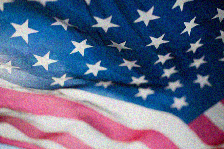

ValueError: ignored

In [ ]:
# Run program
orig_image = 'flag'
style_image = 'colors_wild'

temp_image, _, _, temp_learned_tensor = generate_image(
                            orig_image, 
                            style_image,
                            transfer_model_name='vgg_for_image',
                            learning_rate=.005,
                            num_iterations=100)

Audio Style Transfer

In [ ]:
content = 'song4'
style = 'song3'


In [ ]:
play_content = True

if play_content:
    # Run program
    # EXPERIMENTAL / IN PROGRESS: Using audio as style source

    # initial song
    clip = load_audio_from_URL(audio_name=content, 
                        audio_directory=AUDIO_DIR,
                        audio_options=AUDIO_OPTIONS)
    file_player = audio_player(clip, smoothing=4)

    file_player


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


audio_clip: (441000,)


In [ ]:
play_style = True

if play_style:
    # Run program
    # EXPERIMENTAL / IN PROGRESS: Using audio as style source

    # initial song
    clip = load_audio_from_URL(audio_name=style, 
                        audio_directory=AUDIO_DIR,
                        audio_options=AUDIO_OPTIONS)
    file_player = audio_player(clip, smoothing=4)
    
    file_player


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


audio_clip: (441000,)


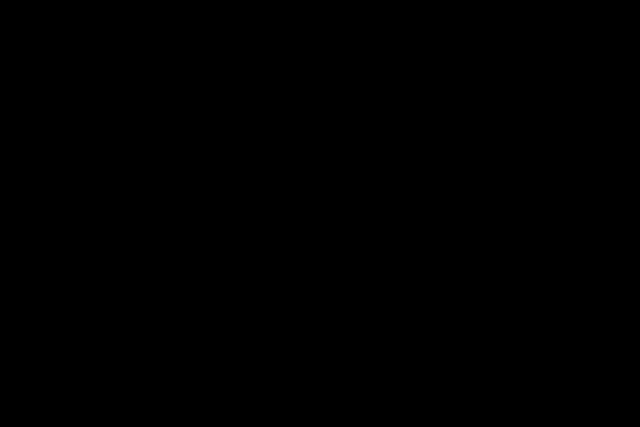

In [ ]:
temp_image, _, _, temp_learned_tensor = \
             generate_image(content, 
                            style,
                            transfer_model_name='vgg_for_audio',
                            learning_rate=.1,
                            num_iterations=500)


# generated song
audio_clip, file_player = tensor_to_audio(temp_learned_tensor, 
                                          transform='Fourier', 
                                          transform_params=AUDIO_TRANSFORM_PARAMS)

file_player = audio_player(audio_clip, smoothing=4)
file_player